### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [4]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


 # Loading Datasets

In [5]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ERA5_16zones_avg_std_10D.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [6]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/tc_act_sind.csv')

In [7]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [8]:
df_target = df_target.rename(columns={'Unnamed: 0': 'DATE'})
df_target = df_target.set_index('DATE')
df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['Label']

df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 15310, dtype: int64

# Compute the compressed representation of the timeseries

In [9]:
# mjo_encoder  = tfk.models.load_model('./models/XGBoost_MJO_64_ERA5_128/MJO_NINO_ENCODER_64.h5')
# era5_encoder = tfk.models.load_model('./models/XGBoost_MJO_64_ERA5_128/ERA5_ENCODER_128.h5')

mjo_encoder  = tfk.models.load_model('./07_Ensemble_Models/models/MJO_NINO_ENCODER.h5')
era5_encoder = tfk.models.load_model('./07_Ensemble_Models/models/ERA5_ENCODER.h5')

print(mjo_encoder.summary())
print(era5_encoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 9)]           0         
                                                                 
 Encoder_Layer_1 (LSTM)      (None, 30, 256)           272384    
                                                                 
 Encoder_Layer_2 (LSTM)      (None, 30, 128)           197120    
                                                                 
 Encoder_Layer_3 (LSTM)      (None, 20)                11920     
                                                                 
Total params: 481424 (1.84 MB)
Trainable params: 481424 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inpu

In [10]:
print(30*9 / 20)
print(11*608 / 512)

13.5
13.0625


In [11]:
def build_timeseries(X, len_timeseries, N_vars):
  X_timeseries = np.zeros((len(X), len_timeseries, N_vars))
  i = 0

  for elem in X:
    j = 0
    for var_idx in range(N_vars):
        idx = var_idx*len_timeseries
        X_timeseries[i, :, j] = elem[idx : idx + len_timeseries]
        j += 1
    i += 1

  return X_timeseries

In [12]:
mjo_timeseries  = build_timeseries(df_mjo_enso.values , 30, 9)
era5_timeseries = build_timeseries(df_era5_scaled.values, 11, 2*16*19)

print(mjo_timeseries.shape, era5_timeseries.shape)

(15310, 30, 9) (15310, 11, 608)


In [13]:
compressed_mjo_timeseries   = mjo_encoder.predict(mjo_timeseries)
compressed_era5_timeseries = era5_encoder.predict(era5_timeseries)

print(compressed_mjo_timeseries.shape, compressed_era5_timeseries.shape)

479/479 [==============================] - 2s 3ms/step
(15310, 20) (15310, 512)


# Build the dataset to train XGBoost

In [14]:
era5_columns = df_era5.columns
selected_columns = []

for elem in era5_columns:
  if '-0' in elem:
    selected_columns.append(elem)
df_era5_D0 = df_era5_scaled[selected_columns]

# Create a mapping dictionary for column renaming
column_mapping = {col: col.split('-')[0] if col.endswith('-0') else col for col in df_era5_D0.columns}
# Rename the columns using the mapping dictionary
df_era5_D0.rename(columns=column_mapping, inplace=True)

df_era5_D0

<ipython-input-14-d250eda1ba77>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_era5_D0.rename(columns=column_mapping, inplace=True)


,P_Mean_Z1,P_Std_Z1,P_Mean_Z2,P_Std_Z2,P_Mean_Z3,P_Std_Z3,P_Mean_Z4,P_Std_Z4,P_Mean_Z5,P_Std_Z5,...,Air_Density_Mean_Z12,Air_Density_Std_Z12,Air_Density_Mean_Z13,Air_Density_Std_Z13,Air_Density_Mean_Z14,Air_Density_Std_Z14,Air_Density_Mean_Z15,Air_Density_Std_Z15,Air_Density_Mean_Z16,Air_Density_Std_Z16
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.225625,0.473038,0.099444,0.485708,0.209731,0.499142,0.126741,0.305865,0.202969,...,0.268514,0.187914,0.335606,0.237152,0.362863,0.279106,0.221570,0.295572,0.350686,0.376670
1980-02-02,0.412313,0.117986,0.552742,0.186564,0.443168,0.357054,0.538519,0.163493,0.322097,0.101406,...,0.296487,0.302868,0.326649,0.245475,0.347638,0.328968,0.247023,0.329454,0.394271,0.404121
1980-02-03,0.376618,0.140311,0.461336,0.173845,0.529018,0.214799,0.594819,0.056027,0.299745,0.070006,...,0.339597,0.304550,0.345126,0.278784,0.305899,0.304352,0.255375,0.393188,0.417157,0.363910
1980-02-04,0.348375,0.140882,0.470298,0.089638,0.578430,0.092791,0.576014,0.114907,0.287197,0.155010,...,0.333598,0.272821,0.338568,0.318168,0.265857,0.416115,0.226126,0.418310,0.398130,0.286136
1980-02-05,0.286090,0.177931,0.449858,0.106383,0.607551,0.058850,0.572071,0.193897,0.233699,0.141282,...,0.344829,0.234698,0.341673,0.303156,0.191426,0.646115,0.192057,0.485791,0.387655,0.241274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.189736,0.572139,0.044496,0.673339,0.101741,0.721869,0.101534,0.322937,0.073352,...,0.337543,0.120454,0.391793,0.471695,0.497461,0.582661,0.294667,0.517691,0.287415,0.293302
2021-12-28,0.489694,0.252822,0.511337,0.095774,0.612586,0.070439,0.592895,0.056472,0.318560,0.050634,...,0.322077,0.162380,0.262433,0.317955,0.469822,0.548677,0.437811,0.497655,0.270666,0.255346
2021-12-29,0.429117,0.258154,0.484355,0.172363,0.468166,0.037967,0.460041,0.090318,0.264105,0.118350,...,0.307245,0.175733,0.240942,0.314818,0.412454,0.584602,0.445609,0.445294,0.311998,0.357800


In [15]:
def build_atts(name, steps):
  new_atts = []
  for i in range(steps):
    new_atts.append('{}_{}'.format(name, i+1))
  return new_atts

compressed_mjo_atts = build_atts('MJO', compressed_mjo_timeseries.shape[1])
compressed_era5_atts = build_atts('ERA5', compressed_era5_timeseries.shape[1])
df_compressed_mjo = pd.DataFrame(compressed_mjo_timeseries, columns = compressed_mjo_atts, index=df_era5.index)
df_compressed_era5 = pd.DataFrame(compressed_era5_timeseries, columns = compressed_era5_atts, index=df_era5.index)

df_compressed_mjo

,MJO_1,MJO_2,MJO_3,MJO_4,MJO_5,MJO_6,MJO_7,MJO_8,MJO_9,MJO_10,MJO_11,MJO_12,MJO_13,MJO_14,MJO_15,MJO_16,MJO_17,MJO_18,MJO_19,MJO_20
DATE,,,,,,,,,,,,,,,,,,,,
1980-02-01,-0.502215,-0.303870,0.091446,0.176396,0.010904,-0.187109,0.054166,0.143922,-0.322996,-0.000400,0.596386,0.177758,-0.165054,0.266306,0.057370,0.250441,-0.055424,-0.130910,-0.181831,0.649106
1980-02-02,-0.496798,-0.304404,0.109199,0.236437,0.048137,-0.179493,0.067961,0.145078,-0.338465,-0.012295,0.583312,0.183551,-0.157497,0.244920,0.054713,0.239522,-0.065498,-0.133565,-0.232988,0.640148
1980-02-03,-0.489488,-0.315940,0.130663,0.266927,0.082490,-0.167635,0.079124,0.151156,-0.353487,-0.025654,0.572404,0.189339,-0.141129,0.214795,0.056276,0.232229,-0.075848,-0.136719,-0.269439,0.617657
1980-02-04,-0.481067,-0.334053,0.156455,0.272103,0.117363,-0.152110,0.088773,0.159616,-0.367021,-0.041155,0.563943,0.193493,-0.121830,0.182794,0.061787,0.231014,-0.086961,-0.139712,-0.295810,0.585168
1980-02-05,-0.472681,-0.356917,0.185133,0.255913,0.154930,-0.131079,0.096590,0.169159,-0.379660,-0.055729,0.556328,0.197935,-0.091205,0.153290,0.068486,0.234787,-0.099638,-0.143288,-0.312263,0.542335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-0.389524,-0.493054,0.041698,0.066551,0.074506,0.397443,-0.353795,0.146931,-0.062565,-0.115879,0.621413,0.219394,0.002533,0.021795,0.139907,0.454179,0.384406,-0.250554,-0.531401,0.566867
2021-12-28,-0.396416,-0.496674,0.027808,0.061468,0.107360,0.395985,-0.366151,0.137606,-0.073221,-0.083371,0.623726,0.241335,0.039640,0.033006,0.150444,0.452788,0.374556,-0.242948,-0.544668,0.570256
2021-12-29,-0.399357,-0.500799,0.017667,0.056421,0.128113,0.396583,-0.375810,0.128168,-0.083156,-0.045715,0.622968,0.261473,0.076628,0.044997,0.161611,0.452775,0.360255,-0.233429,-0.555486,0.570172


In [16]:
df_target[df_target.index > '2012-03-05']

DATE
2012-03-06    0
2012-03-07    1
2012-03-08    1
2012-03-09    1
2012-03-10    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 3588, dtype: int64

In [17]:
test_mjo_timeseries  = df_mjo_enso[df_mjo_enso.index > '2012'].values
test_era5_timeseries = df_era5_scaled[df_era5_scaled.index > '2012'].values
test_era5_d0 = df_era5_D0[df_era5_D0.index > '2012'].values
y_test  = df_target[df_target.index > '2012'].values

print(test_mjo_timeseries.shape, test_era5_timeseries.shape, test_era5_d0.shape, y_test.shape)

(3653, 270) (3653, 6688) (3653, 608) (3653,)


In [18]:
train_mjo_timeseries  = df_mjo_enso[df_mjo_enso.index < '2012'].values
train_era5_timeseries = df_era5_scaled[df_era5_scaled.index < '2012'].values
train_era5_d0 = df_era5_D0[df_era5_D0.index < '2012'].values
y_train  = df_target[df_target.index < '2012'].values

print(train_mjo_timeseries.shape, train_era5_timeseries.shape, train_era5_d0.shape, y_train.shape)

(11657, 270) (11657, 6688) (11657, 608) (11657,)


In [19]:
era5_d0_features = list(df_era5_D0.columns)
era5_timeseries_features = list(df_era5_scaled.columns)
mjo_enso_timeseries_features = list(df_mjo_enso.columns)

print(era5_d0_features, era5_timeseries_features, mjo_enso_timeseries_features)

['P_Mean_Z1', 'P_Std_Z1', 'P_Mean_Z2', 'P_Std_Z2', 'P_Mean_Z3', 'P_Std_Z3', 'P_Mean_Z4', 'P_Std_Z4', 'P_Mean_Z5', 'P_Std_Z5', 'P_Mean_Z6', 'P_Std_Z6', 'P_Mean_Z7', 'P_Std_Z7', 'P_Mean_Z8', 'P_Std_Z8', 'P_Mean_Z9', 'P_Std_Z9', 'P_Mean_Z10', 'P_Std_Z10', 'P_Mean_Z11', 'P_Std_Z11', 'P_Mean_Z12', 'P_Std_Z12', 'P_Mean_Z13', 'P_Std_Z13', 'P_Mean_Z14', 'P_Std_Z14', 'P_Mean_Z15', 'P_Std_Z15', 'P_Mean_Z16', 'P_Std_Z16', 'Vor_850hPa_Mean_Z1', 'Vor_850hPa_Std_Z1', 'Vor_850hPa_Mean_Z2', 'Vor_850hPa_Std_Z2', 'Vor_850hPa_Mean_Z3', 'Vor_850hPa_Std_Z3', 'Vor_850hPa_Mean_Z4', 'Vor_850hPa_Std_Z4', 'Vor_850hPa_Mean_Z5', 'Vor_850hPa_Std_Z5', 'Vor_850hPa_Mean_Z6', 'Vor_850hPa_Std_Z6', 'Vor_850hPa_Mean_Z7', 'Vor_850hPa_Std_Z7', 'Vor_850hPa_Mean_Z8', 'Vor_850hPa_Std_Z8', 'Vor_850hPa_Mean_Z9', 'Vor_850hPa_Std_Z9', 'Vor_850hPa_Mean_Z10', 'Vor_850hPa_Std_Z10', 'Vor_850hPa_Mean_Z11', 'Vor_850hPa_Std_Z11', 'Vor_850hPa_Mean_Z12', 'Vor_850hPa_Std_Z12', 'Vor_850hPa_Mean_Z13', 'Vor_850hPa_Std_Z13', 'Vor_850hPa_Mean_Z

In [20]:
feature_names = era5_d0_features + mjo_enso_timeseries_features + era5_timeseries_features

In [21]:
# Consider both the values of variables today and the compressed version of timeseries
merged_df = pd.merge(df_era5_D0, df_compressed_mjo, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, df_compressed_era5, left_index=True, right_index=True)
merged_df

,P_Mean_Z1,P_Std_Z1,P_Mean_Z2,P_Std_Z2,P_Mean_Z3,P_Std_Z3,P_Mean_Z4,P_Std_Z4,P_Mean_Z5,P_Std_Z5,...,ERA5_503,ERA5_504,ERA5_505,ERA5_506,ERA5_507,ERA5_508,ERA5_509,ERA5_510,ERA5_511,ERA5_512
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.225625,0.473038,0.099444,0.485708,0.209731,0.499142,0.126741,0.305865,0.202969,...,-0.582379,-0.294970,0.183861,-0.281830,0.404205,-0.328121,0.508400,-0.510574,-0.308599,0.082530
1980-02-02,0.412313,0.117986,0.552742,0.186564,0.443168,0.357054,0.538519,0.163493,0.322097,0.101406,...,-0.569016,-0.292703,0.269712,-0.398472,0.423025,-0.320349,0.450824,-0.446956,-0.252632,0.059368
1980-02-03,0.376618,0.140311,0.461336,0.173845,0.529018,0.214799,0.594819,0.056027,0.299745,0.070006,...,-0.515566,-0.311744,0.261213,-0.309363,0.400244,-0.141907,0.469488,-0.347252,-0.231029,0.047450
1980-02-04,0.348375,0.140882,0.470298,0.089638,0.578430,0.092791,0.576014,0.114907,0.287197,0.155010,...,-0.370718,-0.332264,0.187090,-0.180288,0.354577,0.142923,0.578190,-0.321546,-0.283602,0.061801
1980-02-05,0.286090,0.177931,0.449858,0.106383,0.607551,0.058850,0.572071,0.193897,0.233699,0.141282,...,-0.224500,-0.304981,-0.000058,0.016126,0.455022,0.358968,0.691252,-0.318828,-0.323895,0.048177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.189736,0.572139,0.044496,0.673339,0.101741,0.721869,0.101534,0.322937,0.073352,...,0.130739,-0.202293,-0.099354,0.203962,0.333437,0.100230,0.538081,-0.345752,-0.298650,-0.269023
2021-12-28,0.489694,0.252822,0.511337,0.095774,0.612586,0.070439,0.592895,0.056472,0.318560,0.050634,...,0.159424,-0.191724,0.024259,-0.000085,0.354828,0.004603,0.549250,-0.365178,-0.283663,-0.273594
2021-12-29,0.429117,0.258154,0.484355,0.172363,0.468166,0.037967,0.460041,0.090318,0.264105,0.118350,...,0.001213,-0.155691,0.262773,-0.079721,0.344191,-0.049346,0.471729,-0.410025,-0.311038,-0.279287


In [22]:
from datetime import datetime

def day_of_year(date_string):
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    return date_object.timetuple().tm_yday

# Convert to list of day numbers
day_numbers = [day_of_year(date_str) for date_str in merged_df.index]
merged_df['yday'] = day_numbers

merged_df

,P_Mean_Z1,P_Std_Z1,P_Mean_Z2,P_Std_Z2,P_Mean_Z3,P_Std_Z3,P_Mean_Z4,P_Std_Z4,P_Mean_Z5,P_Std_Z5,...,ERA5_504,ERA5_505,ERA5_506,ERA5_507,ERA5_508,ERA5_509,ERA5_510,ERA5_511,ERA5_512,yday
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.225625,0.473038,0.099444,0.485708,0.209731,0.499142,0.126741,0.305865,0.202969,...,-0.294970,0.183861,-0.281830,0.404205,-0.328121,0.508400,-0.510574,-0.308599,0.082530,32
1980-02-02,0.412313,0.117986,0.552742,0.186564,0.443168,0.357054,0.538519,0.163493,0.322097,0.101406,...,-0.292703,0.269712,-0.398472,0.423025,-0.320349,0.450824,-0.446956,-0.252632,0.059368,33
1980-02-03,0.376618,0.140311,0.461336,0.173845,0.529018,0.214799,0.594819,0.056027,0.299745,0.070006,...,-0.311744,0.261213,-0.309363,0.400244,-0.141907,0.469488,-0.347252,-0.231029,0.047450,34
1980-02-04,0.348375,0.140882,0.470298,0.089638,0.578430,0.092791,0.576014,0.114907,0.287197,0.155010,...,-0.332264,0.187090,-0.180288,0.354577,0.142923,0.578190,-0.321546,-0.283602,0.061801,35
1980-02-05,0.286090,0.177931,0.449858,0.106383,0.607551,0.058850,0.572071,0.193897,0.233699,0.141282,...,-0.304981,-0.000058,0.016126,0.455022,0.358968,0.691252,-0.318828,-0.323895,0.048177,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.189736,0.572139,0.044496,0.673339,0.101741,0.721869,0.101534,0.322937,0.073352,...,-0.202293,-0.099354,0.203962,0.333437,0.100230,0.538081,-0.345752,-0.298650,-0.269023,361
2021-12-28,0.489694,0.252822,0.511337,0.095774,0.612586,0.070439,0.592895,0.056472,0.318560,0.050634,...,-0.191724,0.024259,-0.000085,0.354828,0.004603,0.549250,-0.365178,-0.283663,-0.273594,362
2021-12-29,0.429117,0.258154,0.484355,0.172363,0.468166,0.037967,0.460041,0.090318,0.264105,0.118350,...,-0.155691,0.262773,-0.079721,0.344191,-0.049346,0.471729,-0.410025,-0.311038,-0.279287,363


## Split in train test sets

In [23]:
# Split train-test with dates
X_train = merged_df[merged_df.index < '2012'].values
X_test = merged_df[merged_df.index > '2012'].values

y_train = df_target[df_target.index < '2012'].values
y_test  = df_target[df_target.index > '2012'].values

In [24]:
print('TRAIN SET:        ', X_train.shape, y_train.shape)
print('\nTEST SET :        ', X_test.shape , y_test.shape)

neg_N = y_train.shape[0] - np.count_nonzero(y_train)
pos_N = np.count_nonzero(y_train)

print('POSITIVE SAMPLES: ', pos_N)
print('NEGATIVE SAMPLES: ', neg_N)

neg_pos_ratio = round(neg_N/pos_N, 2)
print('NEG-POS RATIO:    ', neg_pos_ratio)

TRAIN SET:         (11657, 1141) (11657,)

TEST SET :         (3653, 1141) (3653,)
POSITIVE SAMPLES:  1669
NEGATIVE SAMPLES:  9988
NEG-POS RATIO:     5.98


## Build dataset to predict at d+1, d+2, ..., d+5


In [25]:
max_lead_time = 10
X_train_future = []
y_train_future = []
X_test_future = []
y_test_future = []

for i in range(max_lead_time):
  X_train_future.append(X_train[:len(X_train)-i])
  y_train_future.append(y_train[i:])
  X_test_future.append(X_test[:len(X_test)-i])
  y_test_future.append(y_test[:len(y_test)-i])
  print('X_train at t+{}:'.format(i+1), X_train_future[i].shape, y_train_future[i].shape)
  print('X_test at t+{} :'.format(i+1), X_test_future[i].shape , y_test_future[i].shape)
  print(X_train_future[i].shape[0] + X_test_future[i].shape[0])
  print('------------------------------------------------')

X_train at t+1: (11657, 1141) (11657,)
X_test at t+1 : (3653, 1141) (3653,)
15310
------------------------------------------------
X_train at t+2: (11656, 1141) (11656,)
X_test at t+2 : (3652, 1141) (3652,)
15308
------------------------------------------------
X_train at t+3: (11655, 1141) (11655,)
X_test at t+3 : (3651, 1141) (3651,)
15306
------------------------------------------------
X_train at t+4: (11654, 1141) (11654,)
X_test at t+4 : (3650, 1141) (3650,)
15304
------------------------------------------------
X_train at t+5: (11653, 1141) (11653,)
X_test at t+5 : (3649, 1141) (3649,)
15302
------------------------------------------------
X_train at t+6: (11652, 1141) (11652,)
X_test at t+6 : (3648, 1141) (3648,)
15300
------------------------------------------------
X_train at t+7: (11651, 1141) (11651,)
X_test at t+7 : (3647, 1141) (3647,)
15298
------------------------------------------------
X_train at t+8: (11650, 1141) (11650,)
X_test at t+8 : (3646, 1141) (3646,)
15296
-

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11657, 1141) (11657,)
(3653, 1141) (3653,)


# Evalute models

In [31]:
ls ./10_Black_Boxes/models/Ensamble

'Copy of XGBoost_ENS_t+10.dat'  'Copy of XGBoost_ENS_t+4.dat'  'Copy of XGBoost_ENS_t+8.dat'
'Copy of XGBoost_ENS_t+1.dat'   'Copy of XGBoost_ENS_t+5.dat'  'Copy of XGBoost_ENS_t+9.dat'
'Copy of XGBoost_ENS_t+2.dat'   'Copy of XGBoost_ENS_t+6.dat'
'Copy of XGBoost_ENS_t+3.dat'   'Copy of XGBoost_ENS_t+7.dat'


In [32]:
models = []
for i in range(max_lead_time):
  models.append(pickle.load(open('./10_Black_Boxes/models/Ensamble/Copy of XGBoost_ENS_t+{}.dat'.format(i+1), "rb")))

In [39]:
models[0]

XGBRFClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=None, colsample_bytree=0.2542067188293853,
                device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=0.007989830269447743, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=250, max_leaves=218,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=789, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, reg_alpha=None, ...)

In [34]:
from metrics import TCStats

res_train   = []
res_test    = []
predictions = []

for i in range(max_lead_time):
  prediction_train = models[i].predict(X_train_future[i]).transpose()
  d = TCStats(y_train_future[i], prediction_train, y_train_future[0], i+1)
  d = np.array(d)
  res_train.append(d)

  prediction_test = models[i].predict(X_test_future[i]).transpose()
  d = TCStats(y_test_future[i], prediction_test, y_test_future[0], i+1)
  d = np.array(d)
  res_test.append(d)

  predictions.append(prediction_test)

  accuracy = sklearn.metrics.accuracy_score(y_test_future[i], prediction_test)
  recall   = sklearn.metrics.recall_score(y_test_future[i], prediction_test)
  f1       = sklearn.metrics.f1_score(y_test_future[i], prediction_test)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

ValueError: Feature shape mismatch, expected: 1140, got 1141

In [ ]:
ls './07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_test_d1.npy'

./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_test_d1.npy


In [ ]:
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_train_d1.npy', X_train_future[0])
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/y_train_d1.npy', y_train_future[0])

# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_test_d1.npy', X_test_future[0])
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/y_test_d1.npy', y_test_future[0])

In [ ]:
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/feature_names.npy', merged_df.columns)

In [ ]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_train = pd.DataFrame(res_train, columns=headers_list)
df_metrics_train = df_metrics_train.set_index('Window Len')
df_metrics_train

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,1669,1613,0,0,18,1595,74,9970,1.12%,98.88%,99.26%,0.74%,0.9557,0.972,0.0112,0.9557,0.9921
2,1668,1594,0,0,14,1580,88,9974,0.88%,99.12%,99.13%,0.87%,0.9472,0.9687,0.0088,0.9472,0.9912
3,1667,1567,0,0,15,1552,115,9973,0.96%,99.04%,98.86%,1.14%,0.931,0.9598,0.0096,0.931,0.9888
4,1666,1558,0,0,10,1548,118,9978,0.64%,99.36%,98.83%,1.17%,0.9292,0.9603,0.0064,0.9292,0.989
5,1665,1545,0,0,6,1539,126,9982,0.39%,99.61%,98.75%,1.25%,0.9243,0.9589,0.0039,0.9243,0.9887
6,1664,1518,0,0,2,1516,148,9986,0.13%,99.87%,98.54%,1.46%,0.9111,0.9529,0.0013,0.9111,0.9871
7,1663,1539,0,0,2,1537,126,9986,0.13%,99.87%,98.75%,1.25%,0.9242,0.96,0.0013,0.9242,0.989
8,1662,1549,0,0,5,1544,118,9983,0.32%,99.68%,98.83%,1.17%,0.929,0.9617,0.0032,0.929,0.9894
9,1662,1556,0,0,5,1551,111,9982,0.32%,99.68%,98.90%,1.10%,0.9332,0.964,0.0032,0.9332,0.99


In [ ]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_test = pd.DataFrame(res_test, columns=headers_list)
df_metrics_test = df_metrics_test.set_index('Window Len')
df_metrics_test

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,508,514,0,0,143,371,137,3002,27.82%,72.18%,95.64%,4.36%,0.7303,0.726,0.2782,0.7303,0.9234
2,508,505,0,0,157,348,160,2987,31.09%,68.91%,94.92%,5.08%,0.685,0.6871,0.3109,0.685,0.9132
3,508,468,0,0,168,300,208,2975,35.90%,64.10%,93.47%,6.53%,0.5906,0.6148,0.359,0.5906,0.897
4,508,445,0,0,194,251,257,2948,43.60%,56.40%,91.98%,8.02%,0.4941,0.5268,0.436,0.4941,0.8764
5,508,420,0,0,203,217,291,2938,48.33%,51.67%,90.99%,9.01%,0.4272,0.4677,0.4833,0.4272,0.8646
6,508,393,0,0,211,182,326,2929,53.69%,46.31%,89.98%,10.02%,0.3583,0.404,0.5369,0.3583,0.8528
7,508,322,0,0,176,146,362,2963,54.66%,45.34%,89.11%,10.89%,0.2874,0.3518,0.5466,0.2874,0.8525
8,508,259,0,0,153,106,402,2985,59.07%,40.93%,88.13%,11.87%,0.2087,0.2764,0.5907,0.2087,0.8478
9,508,210,0,0,133,77,431,3004,63.33%,36.67%,87.45%,12.55%,0.1516,0.2145,0.6333,0.1516,0.8453


In [ ]:
import numpy as np

def brier_skill_score(y_true, y_prob):
    """
    Calculate Brier Skill Score.

    Parameters:
    - y_true: numpy array or pandas Series, true binary labels (0 or 1).
    - y_prob: numpy array or pandas Series, predicted probabilities for the positive class.

    Returns:
    - Brier Skill Score
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Brier Score for the model (predicted probabilities)
    brier_model = np.mean((y_true - y_prob)**2)

    # Brier Score for the climatology (mean of true labels)
    brier_climatology = np.mean((y_true - np.mean(y_true))**2)

    # Brier Skill Score
    brier_skill_score = 1 - (brier_model / brier_climatology)

    return brier_skill_score


bss = []
for i in range(max_lead_time):
  bss.append(brier_skill_score(y_test_future[i], predictions[i]))
  print('BRIER SKILL SCORE AT t+{}: '.format(i+1), brier_skill_score(y_test_future[i], predictions[i]))

BRIER SKILL SCORE AT t+1:  0.3597886909605299
BRIER SKILL SCORE AT t+2:  0.27515727995832573
BRIER SKILL SCORE AT t+3:  0.14021159381803328
BRIER SKILL SCORE AT t+4:  -0.031334422630653114
BRIER SKILL SCORE AT t+5:  -0.12971569814518147
BRIER SKILL SCORE AT t+6:  -0.22810572245348304
BRIER SKILL SCORE AT t+7:  -0.23044728121950664
BRIER SKILL SCORE AT t+8:  -0.26938392978124415
BRIER SKILL SCORE AT t+9:  -0.2900258283780832
BRIER SKILL SCORE AT t+10:  -0.2626345813916118


## Plot results

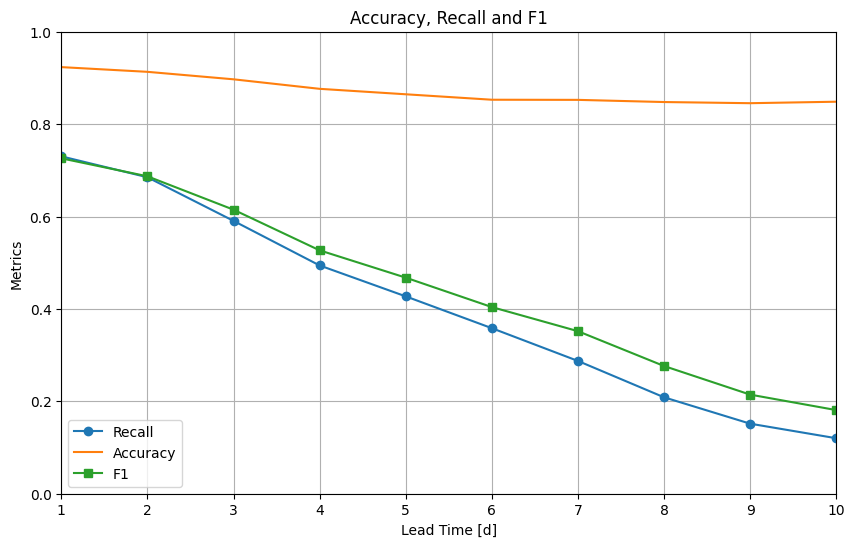

In [ ]:
test_pod = df_metrics_test['POD'].values.astype(float)
test_acc = df_metrics_test['Accuracy'].values.astype(float)
test_f1 = df_metrics_test['F1'].values.astype(float)
test_far = df_metrics_test['False Alarm Ratio'].values.astype(float)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, test_pod, label='Recall', marker='o')
# Plotting Accuracy
plt.plot(x, test_acc, label='Accuracy')
# Plotting F1
plt.plot(x, test_f1, label='F1', marker='s')
# Plotting FAR
#plt.plot(x, test_far, label='FAR', marker='^')

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [d]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
bss_perc = [elem*100 for elem in bss]

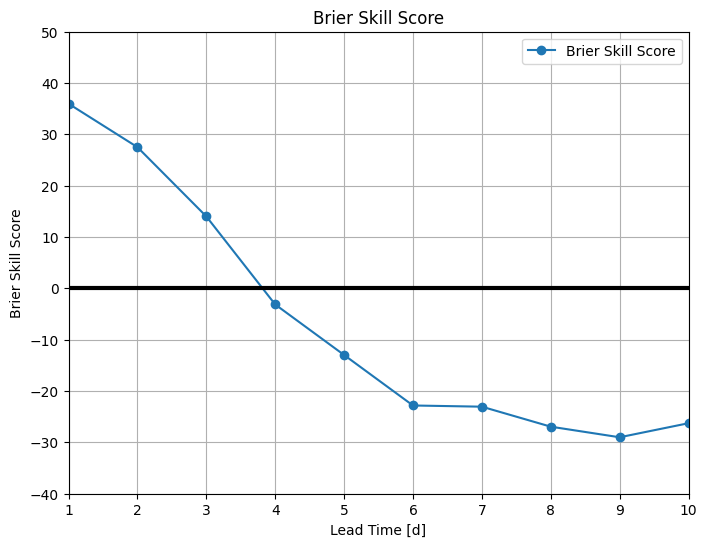

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(8, 6))  # Adjust width and height as needed
# Plotting BSS
plt.plot(x, bss_perc, label='Brier Skill Score', marker='o')

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(-40, 50)  # Adjust the range based on your data
plt.xticks(x)

plt.axhline(y=0, color='black', linewidth=3)
# Adding labels and title
plt.xlabel('Lead Time [d]')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Score')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()